In [1]:
from Utils import PlotUtlis, create_folder, mm2inch, set_mpl_defaults

import os
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import umap.umap_ as umap

set_mpl_defaults()

In [2]:
run_id = 'e52c8ac9a3e24c75ac871f63bbdea060'
exp_id = '115656750127464383'

In [3]:
PU = PlotUtlis(run_id = run_id, exp_id = exp_id)

In [4]:
create_folder(PU.plot_path_embedding_correlation)
create_folder(PU.plot_path_embedding_dimension_reduction)

### Calculatethe relationship betwwen non-environmental species embedding vectors and indices

In [5]:
coocc_counts = PU.set_cooccurrence_counts(species_list = PU.species_list_train)

In [6]:
vec_stack = None
for species in PU.species_list_train:
    if vec_stack is None:
        vec_stack = np.array(PU.coocc_vector[species])[None, :]
    else:
        vec_stack = np.concatenate((vec_stack, np.array(PU.coocc_vector[species])[None, :]))
cos_similarity_matrix = cosine_similarity(vec_stack, vec_stack)
euclidean_distances_matrix = euclidean_distances(vec_stack, vec_stack)

cos_similarity_list = []
euclidean_dist_list = []
for i, data in coocc_counts.iterrows():
    cos_similarity_list.append(cos_similarity_matrix[PU.species_list_train.index(data.sp1), PU.species_list_train.index(data.sp2)])
    euclidean_dist_list.append(euclidean_distances_matrix[PU.species_list_train.index(data.sp1), PU.species_list_train.index(data.sp2)])
coocc_counts['cosine_similarity'] = cos_similarity_list
coocc_counts['euclidean_distance'] = euclidean_dist_list

### plotting

0.62270386590939 0.0


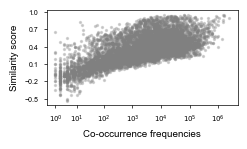

In [7]:
rho, p = scipy.stats.spearmanr(coocc_counts.counts, coocc_counts.cosine_similarity)
print(rho, p)
fig, ax = plt.subplots(figsize = mm2inch(60, 35), constrained_layout = True)
ax.scatter(x = np.log10(coocc_counts.counts+1), 
           y = coocc_counts.cosine_similarity, 
           alpha = 0.3, 
           color =  'grey', 
           s = 2)
ax.set_ylabel('Similarity score')
ax.set_xlabel('Co-occurrence frequencies')

ticks = [1, 10, 100, 1000, 10000, 100000, 1000000]  
ax.set_xticks(np.log10(np.array(ticks)+1))  
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"$10^{{{int(x)}}}$"))  
ax.set_yticks([-0.5, -0.2, 0.1, 0.4, 0.7, 1.0])

plot_output = os.path.join(PU.plot_path_embedding_correlation, 'scatter_cosinesimilarity.pdf')
fig.savefig(plot_output, dpi = 500, transparent = True)

-0.34172191290007237 2.1017609978131236e-194


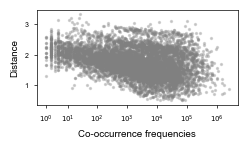

In [8]:
rho, p = scipy.stats.spearmanr(coocc_counts.counts, coocc_counts.euclidean_distance)
print(rho, p)
fig, ax = plt.subplots(figsize = mm2inch(60, 35), constrained_layout = True)
ax.scatter(x = np.log10(coocc_counts.counts+1), 
           y = coocc_counts.euclidean_distance, 
           alpha = 0.3, 
           color = 'grey', 
           s = 2)
ax.set_ylabel('Distance')
ax.set_xlabel('Co-occurrence frequencies')

ticks = [1, 10, 100, 1000, 10000, 100000, 1000000]
ax.set_xticks(np.log10(np.array(ticks)+1))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"$10^{{{int(x)}}}$"))

plot_output = os.path.join(PU.plot_path_embedding_correlation, 'scatter_euclideandistance.pdf')
fig.savefig(img_path, dpi = 500, transparent=True)

### Calculate average elevation of every species

In [9]:
avg_elevation_df = PU.calculate_avg_elev()
avg_elevation_df.to_csv(PU.avg_elev_path, index = None)

print(f'Average elevation data been saved in {PU.avg_elev_path}')

Average elevation data been saved in plots/e52c8ac9a3e24c75ac871f63bbdea060/Fig2_embedding_dimension_reduction/avg_elevation.csv


## Plotting non-environmental species embedding vector based on average elevation

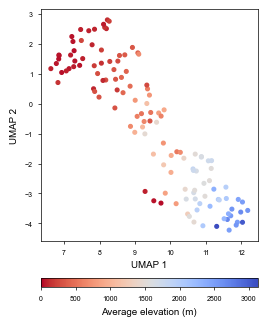

In [10]:
# load avg_elevation_df (if needed)
# avg_elevation_df = pd.read_csv(PU.avg_elev_path)
df_vec = pd.DataFrame([PU.coocc_vector[species] for species in PU.species_list_train])

reducer = umap.UMAP(n_neighbors =  22, n_components=2, random_state=42, n_jobs = 1)
embedding_umap = reducer.fit_transform(df_vec.values)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = mm2inch(65, 80), height_ratios=(25,1), constrained_layout = True)
    
elev_values = [avg_elevation_df[avg_elevation_df.Species == sp].AverageElevation.values.tolist()[0] for sp in PU.species_list_train]
umap_values = [embedding_umap[i] for i, sp in enumerate(PU.species_list_train)]
umap_values = np.array(umap_values)

ax_scatter = ax1.scatter(umap_values[:, 0], umap_values[:, 1], c=elev_values, cmap='coolwarm_r', s=7, vmin = 0)

ax1.set_xlabel('UMAP 1')
ax1.set_ylabel('UMAP 2')

cbar = fig.colorbar(ax_scatter, ax = ax2, orientation='horizontal', cax = ax2)
cbar.set_label('Average elevation (m)')

plot_output = os.path.join(PU.plot_path_embedding_dimension_reduction, 'embedding_umap_elev.pdf')
plt.savefig(plot_output, dpi=200, transparent = True)

plt.show()